In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyqstem import PyQSTEM
from pyqstem.imaging import CTF
from pyqstem.util import atoms_plot
from ase.cluster.cubic import FaceCenteredCubic
from reconstruct import reconstruct

This notebook demonstrates how to recontruct the exit wave from simulated data from a model of a copper nanoparticle.

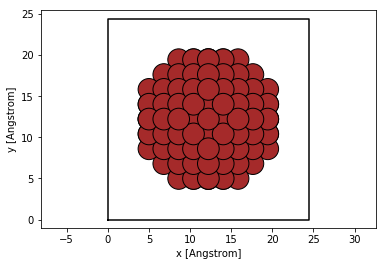

In [18]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [4, 7, 3]
lc = 3.61
atoms = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)
atoms.center(vacuum=5)

atoms_plot(atoms)

The exit wave is simulated for an acceleration voltage of 300 keV.

In [20]:
wave_size=(int(atoms.get_cell()[0,0]*20),int(atoms.get_cell()[1,1]*20))
qstem=PyQSTEM('TEM')
qstem.set_atoms(atoms)
qstem.build_wave('plane',300,wave_size)
qstem.build_potential(int(atoms.get_cell()[2,2]*2))
qstem.run()
wave=qstem.get_wave()

We simulate images at with the parameters given by the table below. The CTFs are saved for use in the reconstruction. 

| Parameter | value |
|------|------|
| Sampling | 0.18 Angstrom/pixel|
| Cs | 11.5 microns|
| Focal spread | 30 Angstrom|
| Dose | 10^4 e-/Angstrom|
| Defocus | -30 nm to +30 nm |


In [22]:
sampling=.18
energy=wave.energy
num_images=6

defocus=np.linspace(-300,300,num_images)
images=[]
ctfs=[]

for i,d in enumerate(defocus):
    ctf=CTF(defocus=d,Cs=-20*10**4,focal_spread=25)
    image=wave.apply_ctf(ctf).detect(resample=sampling, dose=10**4)
    image=image/np.mean(image)
    
    images.append(image)
    ctfs.append(ctf)
    
images=np.array(images)

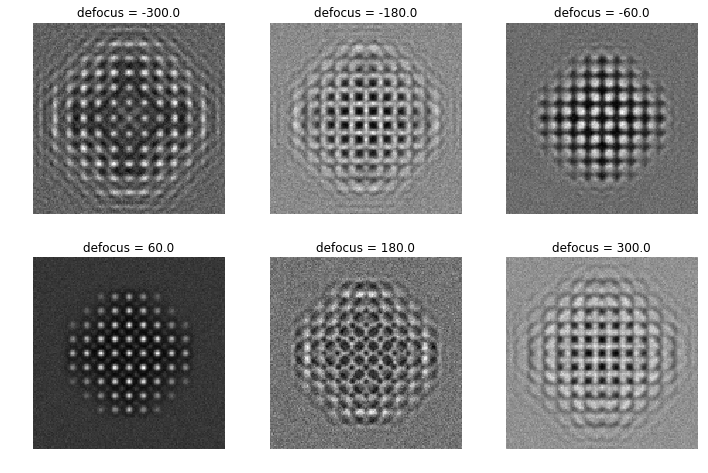

In [23]:
ncol=3
nrow=np.ceil(num_images/ncol).astype(int)

fig,axes=plt.subplots(nrow,ncol,figsize=(10,10*nrow/ncol))

for i,image in enumerate(images):
    m=i//ncol
    n=i%ncol
    
    axes[m,n].imshow(image,cmap='gray')
    axes[m,n].axis('off')
    axes[m,n].set_title('defocus = {0}'.format(defocus[i]))

plt.tight_layout()

We plot one of the CTFs to investigate the cutoff for the maximum reconstructed spatial frequency. The frequencies above this cutoff is assumed to be dominated by noise.

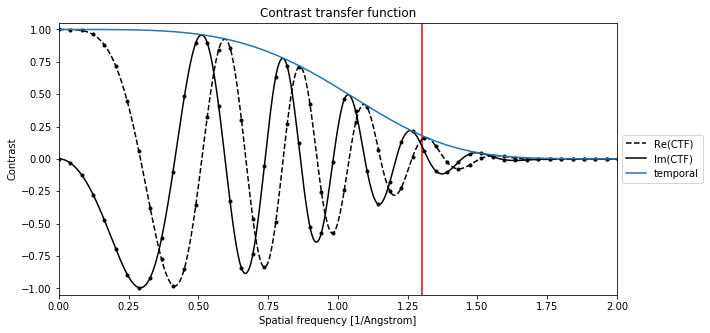

In [16]:
fig,ax=plt.subplots(figsize=(10,5))

cutoff=1.3

ax.axvline(cutoff,color='r')
ctf.radial_plot(ax=ax)

We reconstruct the exit waves.

The quality of the reconstructed exit wave is measured by taking the mean squared error between square root of the input images $I_i$ and the amplitude $A_i$ of the exit waves propated to the corresponding image planes

$$
MSE = \sum_i (\sqrt{I_i} - A_i)^2
$$
where the sum is over all pixels in all images.


In [26]:
help(reconstruct)

Help on function reconstruct in module reconstruct:

reconstruct(images, ctfs, energy, sampling, tolerance=1e-06, cutoff=2, maxiter=50, epsilon=1e-12)
    Reconstruct the exit-plane wavefunction from a series of 
    transmission eletronc microscopy (TEM) images and the assumed 
    corresponding contrast transfer functions(CTFs).
    
    Args:
        images (list of 2d arrays): series of TEM images
        ctfs (list of CTF objects): CTF's corresponding the images
        energy (float): electron energy in keV
        sampling (float): image sampling in Angstrom/pixel
        tolerance (float): mean squared error tolerance
        maxiter (int): maximum number of iterations
        cutoff (float): maximum spatial frequency reconstructed
        epsilon (float): additive constant for avoiding division by zero
    
    Returns:
        Wave object: Reconstructed exit wave



In [27]:
reconstructed = reconstruct(images,ctfs,energy,sampling,tolerance=1e-6,cutoff=cutoff)

 0  : MSE = 0.002820 [inf] 
 1  : MSE = 0.001385 [0.001436] 
 2  : MSE = 0.000988 [0.000396] 
 3  : MSE = 0.000865 [0.000123] 
 4  : MSE = 0.000823 [0.000043] 
 5  : MSE = 0.000806 [0.000017] 
 6  : MSE = 0.000798 [0.000008] 
 7  : MSE = 0.000794 [0.000004] 
 8  : MSE = 0.000791 [0.000003] 
 9  : MSE = 0.000789 [0.000002] 
 10 : MSE = 0.000788 [0.000002] 
 11 : MSE = 0.000787 [0.000001] 
 12 : MSE = 0.000786 [0.000001] 
 13 : MSE = 0.000785 [0.000001] 


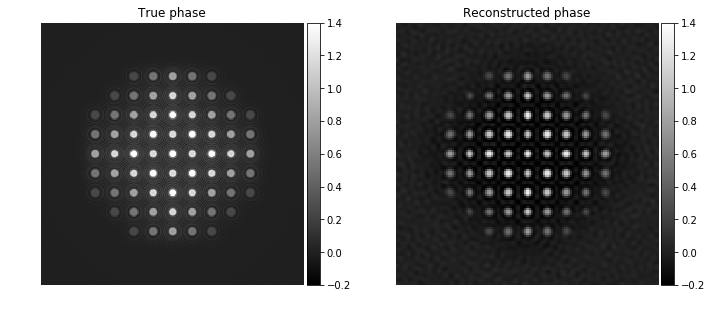

In [28]:
fig,axes=plt.subplots(1,2,figsize=(10,5))

vmin,vmax=-.2,1.4

wave.view(ax=axes[0],method='phase',vmin=vmin,vmax=vmax,title='True phase')
reconstructed.view(ax=axes[1],method='phase',vmin=vmin,vmax=vmax,title='Reconstructed phase')

for ax in axes:
    ax.axis('off')

plt.tight_layout()